In [1]:
addprocs(11)  # parallel computing

11-element Array{Any,1}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12

In [2]:
require("prepare_data_Sioux.jl");
require("extract_data_Sioux.jl");
require("tap_MSA_Sioux.jl");
require("../Julia_files/inverseVI.jl");
require("../Julia_files/demands_adjustment_gradi.jl");

In [3]:
require("initia_data.jl");

In [4]:
demandsDiffDict[1] = norm(demandsDicToVec(demandsDict[1]) - demandsDicToVec(demandsDict[0]))/
norm(demandsDicToVec(demandsDict[0]));

In [5]:
fcoeffs = [1, 0, 0, 0, .15];

# get observed flow vector (corresponding to ground truth demands and ground truth costs)
tapFlowDicDict[0], tapFlowVecDict[0] = tapMSA(demandsDict[0], fcoeffs);

In [6]:
# get arcs data corresponding to ground truth demands and flows
arcsDict[0] = observFlow("../data_original/SiouxFalls_net.txt", tapFlowDicDict[0]);

In [7]:
deg = 6
c = 3.41
lam = 1.

coeffs_dict[(deg, c, lam, 1)], objInvVIDict[1] = train(lam, deg, c, demandsDict[1], arcsDict[0]);

In [8]:
# get initial flow vector (corresponding to initial demands)
tapFlowDicDict[1], tapFlowVecDict[1] = tapMSA(demandsDict[1], coeffs_dict[(deg, c, lam, 1)]);

demandsVecDict[0] = demandsDicToVec(demandsDict[0]);

In [9]:
# get arcs data corresponding to initial demands and flows
arcsDict[1] = observFlow("../data_original/SiouxFalls_net.txt", tapFlowDicDict[1]);

In [10]:
linkCostDicDict[1] = tapFlowVecToLinkCostDict(tapFlowVecDict[1], coeffs_dict[(deg, c, lam, 1)]);

In [11]:
# route choice parameter
tau = 0.5;

In [12]:
jacobiSpiessDict[1] = jacobianSpiess(numLinks, numODpairs, numRoutes, linkRoute, odPairRoute);

In [13]:
# number of iterations
N = 9;  

In [14]:
for iterNumber = 1:N
    
    l = iterNumber;
    
#     jacobDict[l] = jacobian(tapFlowVecDict[l], coeffs_dict[(deg, c, lam, l)], capacity, 
#     free_flow_time, numLinks, numODpairs, numRoutes, linkRoute, odPairRoute);
    
    jacobDict[l] = jacobiSpiessDict[l]

    descDirecDict[l] = descDirec(tapFlowVecDict[l], tapFlowVecDict[0], jacobDict[l], numODpairs, numLinks);

    demandsVecDict[l] = demandsDicToVec(demandsDict[l]);

    searchDirecDict[l] = searchDirec(demandsVecDict[l], descDirecDict[l], 0);

    thetaMaxDict[l] = thetaMax(demandsVecDict[l], searchDirecDict[l]);

    objFunDict[l] = objF(demandsVecDict[l]);

    demandsVecDict[l+1] = similar(demandsVecDict[0]);
    
    demandsVecDict[l+1], objFunDict[l+1] = armijo(demandsVecDict[l], searchDirecDict[l], thetaMaxDict[l], 2, 10);
            
    demandsDict[l+1] = demandsVecToDic(demandsVecDict[l+1]);
    
    tapFlowDicDict[l+1], tapFlowVecDict[l+1] = tapMSA(demandsDict[l+1], coeffs_dict[(deg, c, lam, l)]);
        
    arcsDict[l+1] = observFlow("../data_original/SiouxFalls_net.txt", tapFlowDicDict[l+1]);
        
#     coeffs_dict[(deg, c, lam, l+1)], objInvVIDict[l+1] = train(lam, deg, c, demandsDict[l+1], arcsDict[l+1]);
    coeffs_dict[(deg, c, lam, l+1)], objInvVIDict[l+1] = train(lam, deg, c, demandsDict[l+1], arcsDict[0]);

    linkCostDicDict[l+1] = tapFlowVecToLinkCostDict(tapFlowVecDict[l+1], coeffs_dict[(deg, c, lam, l+1)]);
    
    odPairRouteDict[l+1] = odPairRouteProb(tau, lengthRouteVec(linkCostDicDict[l+1]), OD_pair_route_dict, 
    numODpairs, numRoutes);
    
    jacobiSpiessDict[l+1] = jacobianSpiess(numLinks, numODpairs, numRoutes, linkRoute, odPairRouteDict[l+1]);
        
    demandsDiffDict[l+1] = norm(demandsVecDict[l+1] - demandsVecDict[0]) / norm(demandsVecDict[0]);
        
end

# normalize objective function value
for l = 1:(N+1)
    norObjFunDict[l] = objFunDict[l] / objFunDict[1];
end

In [15]:
demandsVecDict

Dict{Int64,Array{Float64,1}} with 11 entries:
  2  => [125.18827347041744,118.11987450409354,554.4962776233444,215.24936305420…
  0  => [100.0,100.0,500.0,200.0,300.0,500.0,800.0,500.0,1300.0,500.0,200.0,500.…
  7  => [125.33973872010863,118.22596462375327,554.6477610655702,215.47519640603…
  9  => [125.33973872010863,118.22596462375327,554.6477610655702,215.47519640603…
  10 => [125.33973872010863,118.22596462375327,554.6477610655702,215.47519640603…
  8  => [125.33973872010863,118.22596462375327,554.6477610655702,215.47519640603…
  6  => [125.33973872010863,118.22596462375327,554.6477610655702,215.47519640603…
  4  => [125.33938265770335,118.22568578530104,554.6473506497413,215.47457703623…
  3  => [125.33330203796625,118.2209405012601,554.6403234748562,215.464185361862…
  5  => [125.33973872010863,118.22596462375327,554.6477610655702,215.47519640603…
  1  => [118.91664383806138,118.37618359254327,547.6620230848335,209.06157474378…

In [16]:
norObjFunDict

Dict{Int64,Float64} with 10 entries:
  7  => 0.9250589705106237
  4  => 0.9250623746976205
  9  => 0.9250589705106237
  10 => 0.9250589705106237
  2  => 0.9303259209250417
  3  => 0.927367185590151
  5  => 0.9250589705106237
  8  => 0.9250589705106237
  6  => 0.9250589705106237
  1  => 1.0

INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...


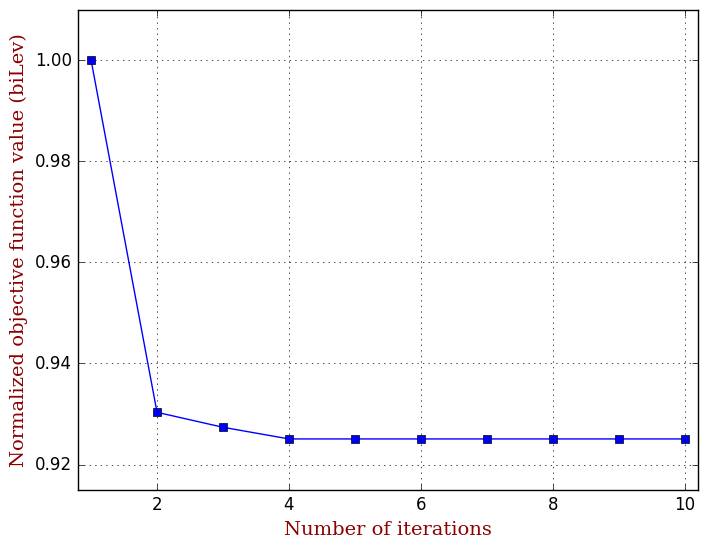

In [17]:
using PyPlot

iterNum = 1:(N+1)

objFun = map(iterNum->norObjFunDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, objFun, "s-b")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, N + 1 + .2)
ylim(minimum(objFun)-.01, maximum(objFun)+.01)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized objective function value (biLev)", fontdict=font1)

savefig("./results/objFun_biLev_Sioux.pdf")

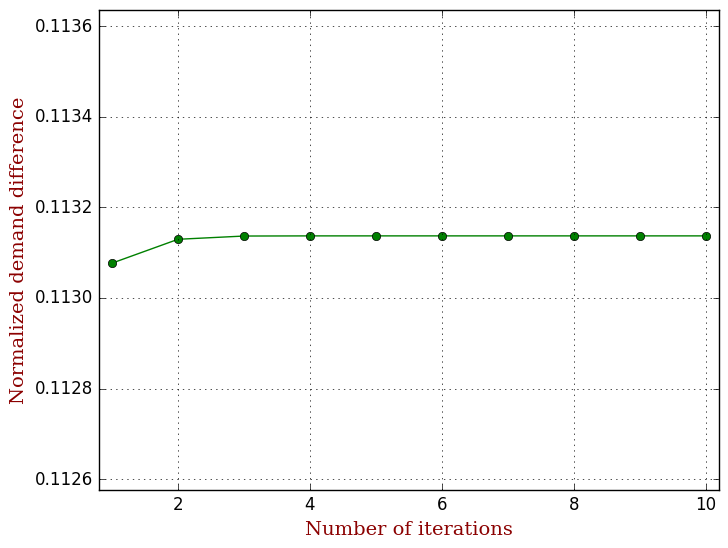

In [18]:
using PyPlot

iterNum = 1:(N+1)

demandsDiff = map(iterNum->demandsDiffDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, demandsDiff, "o-g")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, N + 1 + .2)
ylim(minimum(demandsDiff)-.0005, maximum(demandsDiff)+.0005)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized demand difference", fontdict=font1)

savefig("./results/demandsDiff_biLev_Sioux.pdf")

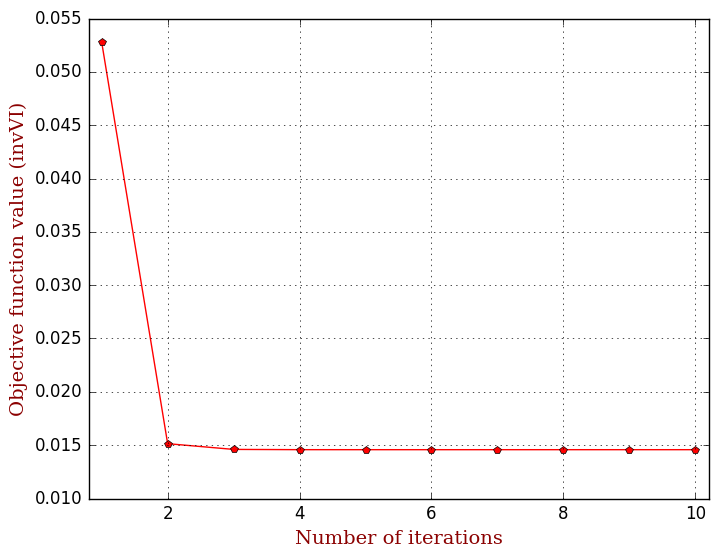

In [19]:
using PyPlot

iterNum = 1:(N+1)

objFun = map(iterNum->objInvVIDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, objFun, "p-r")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(0.8, N + 1 + .2)
# ylim(0.9, 2.0)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Objective function value (invVI)", fontdict=font1)

savefig("./results/objFun_invVI_Sioux.pdf")

In [20]:
coeffs_dict

Dict{(Int64,Float64,Float64,Int64),Array{Float64,1}} with 10 entries:
  (6,3.41,1.0,2)  => [1.0,0.00939027711956827,-0.055380211358399614,0.0846377036…
  (6,3.41,1.0,6)  => [1.0,0.00941954575682685,-0.05550953783019552,0.08484487162…
  (6,3.41,1.0,7)  => [1.0,0.00941954575682685,-0.05550953783019552,0.08484487162…
  (6,3.41,1.0,5)  => [1.0,0.00941954575682685,-0.05550953783019552,0.08484487162…
  (6,3.41,1.0,3)  => [1.0,0.009418234712659632,-0.05550374367220449,0.0848355855…
  (6,3.41,1.0,9)  => [1.0,0.00941954575682685,-0.05550953783019552,0.08484487162…
  (6,3.41,1.0,10) => [1.0,0.00941954575682685,-0.05550953783019552,0.08484487162…
  (6,3.41,1.0,8)  => [1.0,0.00941954575682685,-0.05550953783019552,0.08484487162…
  (6,3.41,1.0,4)  => [1.0,0.009419473088555232,-0.05550921588098668,0.0848443526…
  (6,3.41,1.0,1)  => [1.0,0.025793763525421325,-0.10446842741934277,0.0876771639…

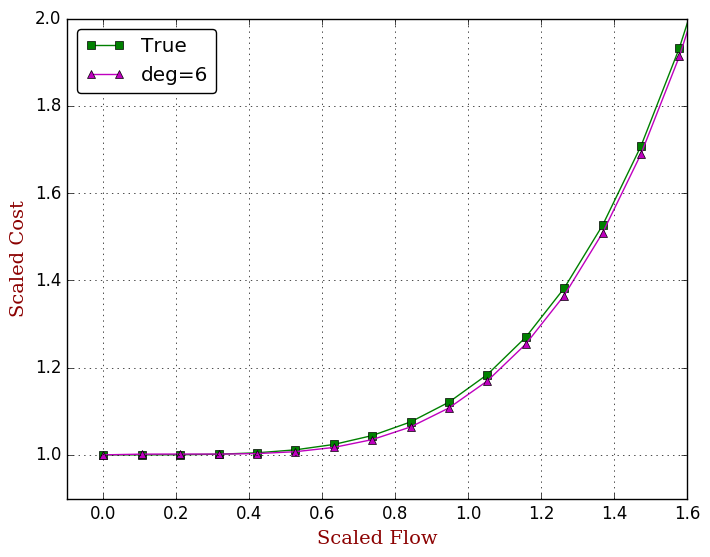

In [21]:
using PyPlot

iterN = 1

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_iter_$(iterN).pdf")

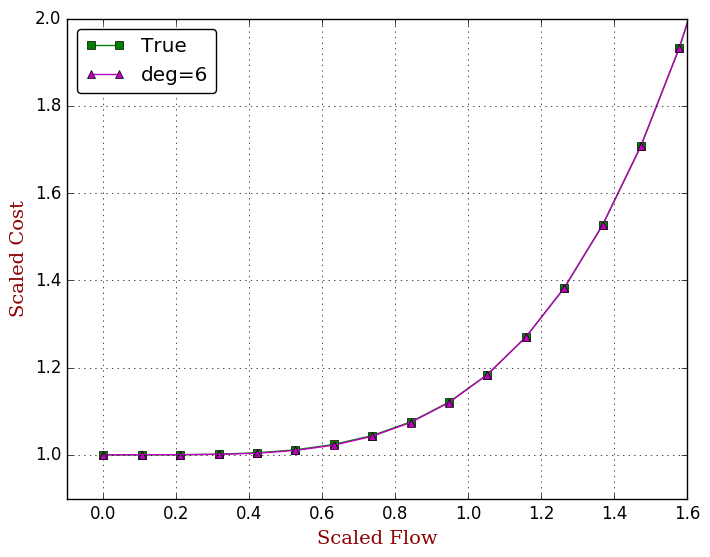

In [22]:
using PyPlot

iterN = 2

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_iter_$(iterN).pdf")

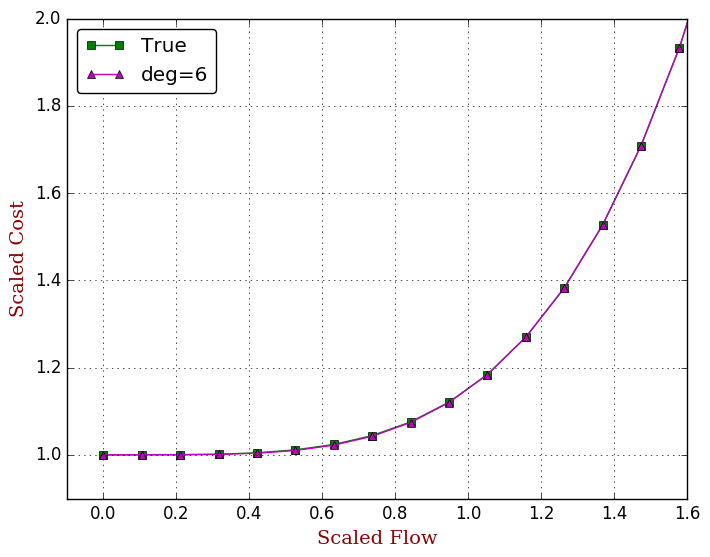

In [23]:
using PyPlot

iterN = 3

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_iter_$(iterN).pdf")

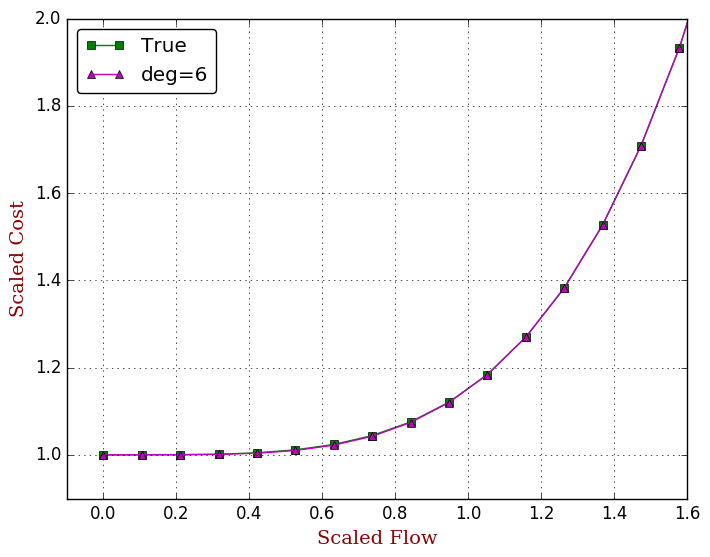

In [24]:
using PyPlot

iterN = N+1

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_iter_$(iterN).pdf")